<a href="https://colab.research.google.com/github/lazybuttrying/TensorFlow-Certificate/blob/main/C4/W4/sunspot_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2021-11-18 14:29:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-11-18 14:29:26 (5.59 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



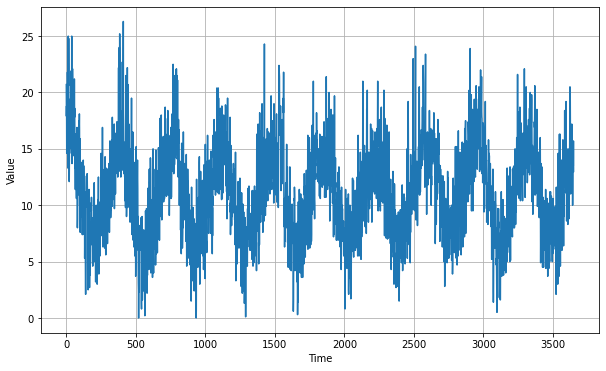

In [4]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [15]:
split_time = 3000 # 총 3500개 이니 2500개를 train으로, 
# 3000개로 시도하심
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30 ##fix
batch_size = 32
shuffle_buffer_size = 1000


In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60 ### 60
batch_size = 256 ### 64->256 : train loss가 감소 시 부드럽게 감소하도록

In [19]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 5s 54ms/step - loss: 31.5937 - mae: 32.0916 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 65ms/step - loss: 30.8629 - mae: 31.3606 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 63ms/step - loss: 29.7727 - mae: 30.2701 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 63ms/step - loss: 28.4158 - mae: 28.9129 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 62ms/step - loss: 26.7471 - mae: 27.2440 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 68ms/step - loss: 24.6218 - mae: 25.1183 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 64ms/step - loss: 21.8499 - mae: 22.3462 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 64ms/step - loss: 18.2811 - mae: 18.7764 - l

(1e-08, 0.0001, 0.0, 60.0)

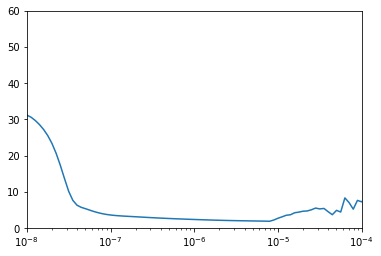

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

(1e-08, 0.0001, 0.0, 60.0)

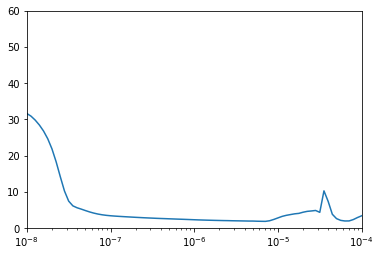

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)
# try epoch 200

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 40ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 1s 39ms/step - loss: 2.5295 - mae: 2.9923
Epoch 3/150
25/25 [==============================] - 1s 38ms/step - loss: 1.9503 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 1s 39ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 1s 39ms/step - loss: 1.8214 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 1s 39ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 1s 39ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 1s 38ms/step - loss: 1.7412 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 1s 38ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 1s 41ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


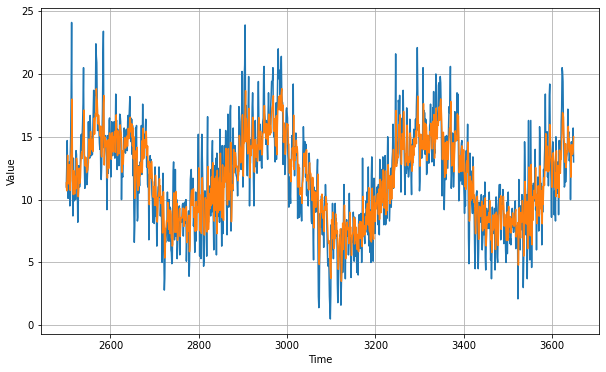

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796156

In [14]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.328855 10.705664 12.124518 ... 13.603929 13.795882 15.008213]


Epoch 1/150
30/30 [==============================] - 6s 39ms/step - loss: 8.7986 - mae: 9.2837
Epoch 2/150
30/30 [==============================] - 2s 41ms/step - loss: 2.2467 - mae: 2.7063
Epoch 3/150
30/30 [==============================] - 1s 40ms/step - loss: 1.8766 - mae: 2.3300
Epoch 4/150
30/30 [==============================] - 1s 40ms/step - loss: 1.8225 - mae: 2.2745
Epoch 5/150
30/30 [==============================] - 2s 41ms/step - loss: 1.7836 - mae: 2.2346
Epoch 6/150
30/30 [==============================] - 1s 40ms/step - loss: 1.7489 - mae: 2.1989
Epoch 7/150
30/30 [==============================] - 1s 39ms/step - loss: 1.7215 - mae: 2.1709
Epoch 8/150
30/30 [==============================] - 1s 40ms/step - loss: 1.6996 - mae: 2.1484
Epoch 9/150
30/30 [==============================] - 1s 40ms/step - loss: 1.6765 - mae: 2.1243
Epoch 10/150
30/30 [==============================] - 1s 40ms/step - loss: 1.6638 - mae: 2.1108
Epoch 11/150
30/30 [=============================

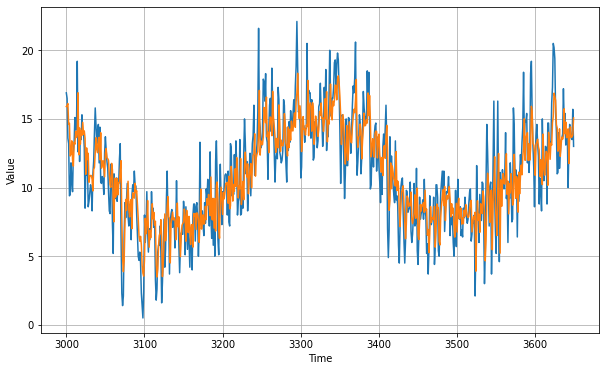

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

In [23]:

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # ㅎㅎ

1.7388616